<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Домашнее задание № 8
## <center> Vowpal Wabbit в задаче прогнозирования популярности статьи на хабре

В этом задании надо побить бенчмарк в [соревновании](https://www.kaggle.com/c/habr-num-bookmarks) на Kaggle Inclass. Как это делать – ограничений нет (кроме, конечно, ручной разметки), прочитать правила можно [тут](https://www.kaggle.com/c/habr-num-bookmarks/rules). Ниже описаны инструкции, как это сделать с Vowpal Wabbit.

Дедлайн: 31 октября 23:59 UTC +3. Решение надо будет загрузить по [ссылке](https://www.dropbox.com/request/g5WOPrxwvcYwADZCuoY7). В этом соревновании нет задачи победить. Цель – побить бенчмарк и продвинуться в [соревновании](https://mlcourse.arktur.io) по прогнозу популярности статьи на Medium. 

In [26]:
import numpy as np
import pandas as pd
import json
import re
from tqdm import tqdm_notebook
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%matplotlib inline

Посмотрим на одну из строчек в JSON-файле: считаем ее с помощью библиотеки json. Эта строчка соответствует [7-ой статье](https://habrahabr.ru/post/7/) на Хабре.

In [2]:
!head -1 train.json > train1.json

In [141]:
#!head -2 train.json

In [4]:
with open('train1.json') as inp_json:
    first_json = json.load(inp_json)

In [5]:
first_json.keys()

dict_keys(['domain', 'flow', 'post_id', 'content', 'published', 'polling', 'flags', 'author', 'hubs', 'title', 'link_tags', 'url', '_timestamp', 'meta_tags', 'tags', '_id'])

Видим 16 полей, перечислим некоторые из них:
- _id, url - URL статьи
- published – время публикации статьи
- domain – сайт (например, habrahahbr.ru или geektimes.ru)
- title – название статьи
- content – текст статьи
- hubs - перечисление хабов, к которым относится статья
- tags – теги статьи
- author – автор статьи, его ник и ссылка на профиль

In [6]:
first_json['_id']

'https://habrahabr.ru/post/7/'

In [7]:
first_json['_timestamp']

1493192186.0903192

In [8]:
first_json['url']

'https://habrahabr.ru/post/7/'

In [9]:
first_json['domain']

'habrahabr.ru'

In [10]:
first_json['published']

{'$date': '2006-07-15T01:48:00.000Z'}

In [11]:
first_json['title']

'Самопроизвольное разлогинивание'

In [12]:
first_json['content']

'У меня такое ощущение, что logout время от времени происходит самопроизвольно, несмотря на то, что чекбокс про логине включен.<br>\r\n<br>\r\nВозможно, это происходит при смене IP-адреса, но я не уверен.'

In [13]:
first_json['polling']

In [14]:
first_json['post_id']

7

In [15]:
first_json['flags']

[]

In [16]:
first_json['hubs']

[{'id': 'hub/habr',
  'title': 'Хабрахабр',
  'url': 'https://habrahabr.ru/hub/habr/'}]

In [17]:
first_json['flow']

In [18]:
first_json['tags']

['логин', 'login']

In [19]:
first_json['author']

{'name': 'Павел Титов',
 'nickname': '@ptitov',
 'url': 'https://habrahabr.ru/users/ptitov'}

In [20]:
first_json['link_tags']

{'alternate': 'https://habrahabr.ru/rss/post/7/',
 'apple-touch-icon-precomposed': '/images/favicons/apple-touch-icon-152x152.png',
 'canonical': 'https://habrahabr.ru/post/7/',
 'icon': '/images/favicons/favicon-16x16.png',
 'image_src': 'https://habrahabr.ru/i/habralogo.jpg',
 'stylesheet': 'https://habracdn.net/habr/styles/1493134745/_build/global_main.css'}

In [21]:
first_json['meta_tags']

{'al:android:app_name': 'Habrahabr',
 'al:android:package': 'ru.habrahabr',
 'al:android:url': 'habrahabr://post/7',
 'al:windows_phone:app_id': '460a6bd6-8955-470f-935e-9ea1726a6060',
 'al:windows_phone:app_name': 'Habrahabr',
 'al:windows_phone:url': 'habrahabr://post/7',
 'apple-mobile-web-app-title': 'Хабрахабр',
 'application-name': 'Хабрахабр',
 'description': 'У меня такое ощущение, что logout время от времени происходит самопроизвольно, несмотря на то, что чекбокс про логине включен.\r\n\r\nВозможно, это происходит при смене IP-адреса, но я не уверен.',
 'fb:app_id': '444736788986613',
 'keywords': 'логин, login',
 'msapplication-TileColor': '#FFFFFF',
 'msapplication-TileImage': 'mstile-144x144.png',
 'og:description': 'У меня такое ощущение, что logout время от времени происходит самопроизвольно, несмотря на то, что чекбокс про логине включен.  Возможно, это происходит при...',
 'og:image': 'https://habrahabr.ru/i/habralogo.jpg',
 'og:title': 'Самопроизвольное разлогинивание'

Загрузим ответы на обучающей выборке.

In [2]:
train_target = pd.read_csv('train_target.csv',
                          index_col='url')

In [3]:
train_target.head()

,target
url,
https://habrahabr.ru/post/7/,0.693147
https://geektimes.ru/post/11/,1.098612
https://geektimes.ru/post/112/,0.000000
https://geektimes.ru/post/1127/,0.000000
https://geektimes.ru/post/12664/,0.000000


In [4]:
train_target.sort_values('target', ascending=False).head()

,target
url,
https://habrahabr.ru/post/250621/,9.080687
https://habrahabr.ru/post/271279/,8.291045
https://habrahabr.ru/post/247367/,8.157657
https://habrahabr.ru/post/278827/,8.154500
https://geektimes.ru/post/82641/,8.153925


Сформируйте обучающую выборку для Vowpal Wabbit, выберите признаки title, tags, domain, flow, author, и hubs из JSON-файла.
От самого текста для начала просто возьмем его длину: постройте признак content_len – длина текста в миллионах символов.
Также постройте признаки: час и месяц публикации статьи. Еще, конечно же, возьмите ответы на обучающей выборке из `train_target`. Ниже пример того, как могут выглядеть первые две строки нового файла.

In [5]:
d = train_target.to_dict()['target']

In [6]:
def prepare(text):
    return ' '.join([e.lower() for e in re.findall("\w+", text, re.UNICODE)])

In [77]:
with open('habr_train.vw', 'w', encoding='utf-8') as fout, \
     open('train.json') as inp_json:
    k = 0
    for line in tqdm_notebook(inp_json):
        first_json = json.loads(line)
        s = str(d[first_json['_id']]) + ' '
        s += '|title ' + prepare(first_json['title']) + ' '
        s += '|tags ' + prepare(' '.join(first_json['tags'])) + ' '
        s += '|domain ' + first_json['domain'] + ' '
        s += '|flow ' + prepare(str(first_json['flow'])) + ' '
        try:
            s += '|author ' + prepare(str(first_json['author']['nickname'])) + ' '
        except:
            print(first_json['author'])
            raise
        s += '|hubs ' + prepare(' '.join([e['title'] for e in first_json['hubs']])) + ' '
        s += '|num '
        s += 'content_len:{}'.format(len(first_json['content']) / 1e6) + ' '
        s += 'month:{}'.format(int(first_json['published']['$date'].split('-')[1])) + ' '
        s += 'hour:{}'.format(int(first_json['published']['$date'][11:13])) + ' '
        
        fout.write(s + '\n')
        k += 1
        #if k == 2:
        #    break

44249it [00:40, 1103.94it/s]



In [75]:
!head -2 habr_train.vw

0.693147 |title самопроизвольное разлогинивание |tags логин login |domain habrahabr ru |flow none |author ptitov |hubs хабрахабр |num content_len:0.000199 month:7 hour:1 
1.098612 |title stand along cообщества против сообществ в рамках социальных сетей |tags сообщества интернет сообщество социальные сети нишевой бренд |domain geektimes ru |flow none |author alexbruce |hubs чёрная дыра |num content_len:0.000988 month:7 hour:14 


In [23]:
#!head -2 ../../data/habr_train.vw

0.6931470000000001 |title Самопроизвольное разлогинивание |tags логин login |domain habrahabr.ru |flow None |author @ptitov |hubs Хабрахабр |num content_len:0.0 month:7 hour:1
1.0986120000000001 |title Stand-along cообщества против сообществ в рамках социальных сетей |tags сообщества интернет-сообщество социальные сети нишевой бренд |domain geektimes.ru |flow None |author @AlexBruce |hubs Чёрная дыра |num content_len:0.0 month:7 hour:14


Проделайте все то же с тестовой выборкой, вместо ответов подсовывая что угодно, например, единицы.

In [78]:
with open('habr_test.vw', 'w', encoding='utf-8') as fout, \
     open('test.json') as inp_json:
    k = 0
    for line in tqdm_notebook(inp_json):
        first_json = json.loads(line)
        s = str(1) + ' '
        s += '|title ' + prepare(first_json['title']) + ' '
        s += '|tags ' + prepare(' '.join(first_json['tags'])) + ' '
        s += '|domain ' + first_json['domain'] + ' '
        s += '|flow ' + prepare(str(first_json['flow'])) + ' '
        s += '|author ' + prepare(str(first_json['author']['nickname'])) + ' '
        s += '|hubs ' + prepare(' '.join([e['title'] for e in first_json['hubs']])) + ' '
        s += '|num '
        s += 'content_len:{}'.format(len(first_json['content']) / 1e6) + ' '
        s += 'month:{}'.format(int(first_json['published']['$date'].split('-')[1])) + ' '
        s += 'hour:{}'.format(int(first_json['published']['$date'][11:13])) + ' '
        
        fout.write(s + '\n')
        k += 1

In [81]:
!head -2 habr_test.vw

1 |title день пи |tags пи pi |domain geektimes.ru |flow none |author timursan |hubs чёрная дыра |num content_len:0.000228 month:3 hour:3 
1 |title скрипт для разбиения образов музыкальных cd на треки и конвертации в формат flac |tags bash lossless |domain geektimes.ru |flow none |author da3mon |hubs чёрная дыра |num content_len:0.009377 month:3 hour:0 


In [24]:
!head -2 ../../data/habr_test.vw

1 |title День Пи! |tags Пи Pi |domain geektimes.ru |flow None |author @Timursan |hubs Чёрная дыра |num content_len:0.0 month:3 hour:3
1 |title Скрипт для разбиения образов музыкальных CD на треки и конвертации в формат FLAC |tags bash lossless |domain geektimes.ru |flow None |author @da3mon |hubs Чёрная дыра |num content_len:0.01 month:3 hour:0


Выбор того, как валидировать модель, остается за Вами. Проще всего, конечно, сделать отложенную выборку. Бенчмарк, который Вы видите в соревновании (**vw_baseline.csv**) и который надо побить, получен с Vowpal Wabbit, 3 проходами по выборке (не забываем удалять кэш), биграммами и настроенными гиперпараметрами `bits`, `learning_rate` и `power_t`. 

In [145]:
#!vw --help

In [85]:
!head -n 10000 habr_train.vw > habr_train_head10000.vw
!head -n 100000 habr_train.vw > habr_train_head100000.vw
!tail -n 20000 habr_train.vw > habr_train_tail20000.vw

In [44]:
lines = []
with open('habr_train.vw') as fin:
    for line in fin:
        lines.append(line)

np.random.seed(7)

ind = np.linspace(0, len(lines) - 1, len(lines), dtype=int)
np.random.shuffle(ind)
with open('habr_train_shuffle.vw', 'w', encoding='utf-8') as fout:
    for i in ind:
        fout.write(lines[i])

In [47]:
ind

array([ 7266, 45374, 23445, ..., 49689, 58564, 61615])

In [69]:
ind1 = np.zeros(len(ind))
for i,v in enumerate(ind):
    ind1[v] = i

In [70]:
train_target['ind'] = ind1

In [71]:
ttt = train_target.sort_values('ind')

In [144]:
ttt.head()

,target,ind
url,,
https://habrahabr.ru/post/186574/,3.850148,0.0
https://habrahabr.ru/company/sap/blog/261045/,3.044522,1.0
https://geektimes.ru/post/226691/,3.806662,2.0
https://habrahabr.ru/post/307148/,4.510860,3.0
https://geektimes.ru/post/14412/,1.098612,4.0


In [76]:
!head -n 100000 habr_train_shuffle.vw > habr_train_head100000.vw
!tail -n 20000 habr_train_shuffle.vw > habr_train_tail20000.vw

In [128]:
# Ваш код здесь
errors = dict()
for lr in np.linspace(0.5, 0.5, 1):
    for pt in np.linspace(0.3, 0.3, 1):
        for bits in np.linspace(22, 22, 1):
            print('==========================================')
            print(str(lr) + ' ' + str(pt) + ' ' + str(bits))
            print('==========================================')
            bb = int(bits)
            !vw -d habr_train_head100000.vw --loss_function quantile -f habr_train_head100000_model.vw \
            -b $bb --random_seed 17 -c \
            --passes 5 --ngram 2 --quiet --learning_rate $lr --power_t $pt

            !vw -i habr_train_head100000_model.vw -c -t -d habr_train_tail20000.vw -p predictions_tail20000.txt

            with open('predictions_tail20000.txt') as pred_file:
                test_prediction = [float(label) 
                                     for label in pred_file.readlines()]

            err = mean_absolute_error(ttt[-20000:]['target'], test_prediction)
            errors[str(lr) + ' ' + str(pt) + ' ' + str(bits)] = err

0.5 0.3 22.0
Generating 2-grams for all namespaces.
only testing
predictions = predictions_tail20000.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using cache_file = habr_train_tail20000.vw.cache
ignoring text input in favor of cache input
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.092438 0.092438            1            1.0   3.6636   3.3595       35
0.048897 0.005357            2            2.0   0.6931   0.7663       43
0.284429 0.519960            4            4.0   4.2341   3.3004       35
0.456337 0.628246            8            8.0   0.0000   0.0000       35
0.643528 0.830719           16           16.0   2.7726   1.3466       53
0.778344 0.913160           32           32.0   1.3863   2.1793       27
0.824993 0.871642           64           64.0   3.1355   0.9168       21
1.132283 1.439573          128          128.0   0.0000   2.9

In [130]:
sorted(errors.items(), key=lambda x: x[1])

[('0.5 0.3 22.0', 0.85441247519999997)]

In [131]:
bb = 22
lr = 0.5
pt = 0.3

In [132]:
!vw -d habr_train_shuffle.vw --loss_function quantile -f habr_train_model.vw \
-b $bb --random_seed 17 -c --passes 5 --ngram 2 --quiet --learning_rate $lr --power_t $pt

In [133]:
!vw -i habr_train_model.vw -t -d habr_test.vw -p predictions_test.txt

Generating 2-grams for all namespaces.
only testing
predictions = predictions_test.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = habr_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.001376 0.001376            1            1.0   1.0000   1.0371       19
0.256941 0.512506            2            2.0   1.0000   1.7159       39
1.029394 1.801846            4            4.0   1.0000   2.8967       29
1.518309 2.007224            8            8.0   1.0000   2.9053       27
2.270797 3.023286           16           16.0   1.0000   0.0000       25
2.335580 2.400363           32           32.0   1.0000   3.3845       27
2.263608 2.191637           64           64.0   1.0000   1.4580       31
2.359084 2.454561          128          128.0   1.0000   2.8869       33
2.209123 2.059161          256          256.0   1.0

In [109]:
# with open('predictions_tail20000.txt') as pred_file:
#     test_prediction = [float(label) 
#                              for label in pred_file.readlines()]

# err = mean_absolute_error(train_target[-20000:]['target'], test_prediction)
# err

0.98371253030000005

In [134]:
with open('predictions_test.txt') as pred_file:
    test_prediction = [float(label) 
                          for label in pred_file.readlines()]

In [135]:
sample_sub = pd.read_csv('sample_submission.csv', 
                         index_col='url')

In [136]:
sample_sub.head()

,target
url,
https://geektimes.ru/post/87455/,11.620054
https://geektimes.ru/post/87452/,4.822528
https://geektimes.ru/post/87459/,0.921104
https://habrahabr.ru/post/87461/,1.632126
https://habrahabr.ru/post/5754/,1.952122


In [137]:
your_submission = sample_sub.copy()
your_submission['target'] = test_prediction
your_submission.to_csv('submission_4.csv')

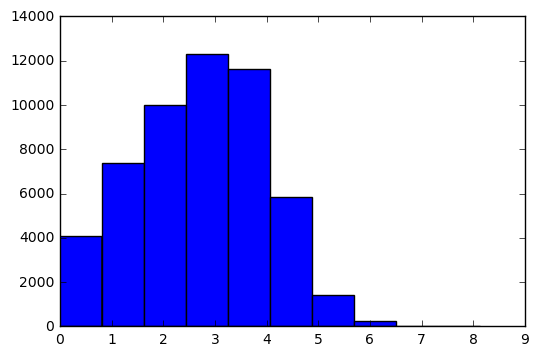

In [138]:
plt.hist(your_submission.target);

In [143]:
your_submission.head()

,target
url,
https://geektimes.ru/post/87455/,1.037097
https://geektimes.ru/post/87452/,1.715895
https://geektimes.ru/post/87459/,0.922058
https://habrahabr.ru/post/87461/,2.896739
https://habrahabr.ru/post/5754/,0.000000


Для получения баллов в #mlcourse_open команда (из 1 человека) должна называться в точном соответствии с тем, как оно записано в рейтинге.